The notebook downloads Sentinel-1 RTC (Radiometrically Terrain Corrected) data and processes it over the specified bounding box. In this example, the bounding box is from a coast off Germany. The RTC achieves this by analyzing the light reflected back from the objects to the satellite sensor.

*Disclaimer*: This notebook must run on the Microsoft Planetary Computer and the code is built upon this repo: https://gist.github.com/calebrob6/364506877a0ed011bb51a707fbc13ff3

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.features
import pystac_client
import planetary_computer as pc
import stackstac
import rtree
import fiona
import fiona.transform
import shapely.geometry

from IPython.display import Image


*Importing these libraries enable the handling of satellite imagery:*
rasterio- reading, writing geospatial data
stackstac- stacking STAC (SpatioTemporal Asset Catalog) items into an xarray.Dataset
shapely- providing geometric objects and operations on them
fiona- used for reading and writing geospatial vector data
numpy- general data processing

In [3]:

bbox = [5.7458, 53.7594, 7.1686, 54.1994]  # off the north coast of Germany
# for more time steps of over same area
date_ranges = ["2022-07-19/2022-08-19", "2022-06-19/2022-07-19", "2022-05-19/2022-06-19", "2022-04-19/2022-05-19"]

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime=date_ranges
)
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Image(url=item.assets["rendered_preview"].href)


Found 20 items


Using the pystac_client and planetary_computer libraries, the script connects to Microsoft's Planetary Computer STAC API, and fetches Sentinel-1 RTC (Radar Topography Mission) data for the defined bounding box and for a specific period and displays the raw satellite image.

In [ ]:
ds = stackstac.stack(
    pc.sign(items), bounds_latlon=bbox, epsg=item.properties['proj:epsg'], resolution=10
)
ds

The images collection (which are multiple images covering the same area at different times) is stacked into a single 3D array (like a cube of images). Each slice of this cube is an image from a different time. The cube is then converted to a 2D array by taking the mean of the cube along the time dimension. This is called temporal mean compositing. The resulting image is a single image that represents the average of all the images in the cube. This is done to reduce the noise in the image.

In [ ]:

img = ds[0,0].values
plt.figure(figsize=(13.5,7.5))
plt.imshow(np.log(img), vmax=-3)
plt.title("VV polarization", fontsize=15)
plt.axis("off")
plt.show()
plt.close()

Create a figure by extracting the first band from the xarray.Dataset and then display the logarithm of the image values. This can be useful to spot differences in reflectivity that could be due to different types of objects on the ground.

In [ ]:
plt.figure(figsize=(13.5,7.5))
plt.imshow(img, vmax=0.1)
plt.title("VV polarization", fontsize=15)
plt.axis("off")
plt.show()
plt.close()

mask = ds > 0.3
mask_nan = ds.notnull()
vals = (mask & mask_nan).sum(axis=(0,1), dtype=float) / mask_nan.sum(axis=(0,1), dtype=float)

Then create a binary mask of pixels where the reflectivity is greater than 0.3.
Another mask to exclude any Not a Number values in the dataset.
Then apply the mask to the image and display the masked image.

In [ ]:
%%time
vals = vals.compute()

Then compute the fraction of true pixels where the reflectivity is greater than 0.3. This is the fraction of pixels that are not water.

In [ ]:
plt.figure(figsize=(13.5,7.5))
plt.imshow(vals, vmin=0, vmax=0.3)
plt.title("Fraction of observations in which a pixel has value > 0.3", fontsize=15)
plt.axis("off")
plt.show()
plt.close()

Now compute a binary mask of pixels where the reflectivity is greater than a specified threshold (0.3 in this case). The mask is True where the condition is met and False otherwise.

In [ ]:
# Modifying this list to include the dates for persistent polygons
date_ranges = ["2022-07-19/2022-08-19", "2022-06-19/2022-07-19", "2022-05-19/2022-06-19"]

persisting_polygons = []
persisting_features = []
elongation_threshold = 2.75 # more adjusting needed


for date_range in date_ranges:
    # repeat the search and polygon extraction process for each date range
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox, datetime=date_range
    )
    items = search.item_collection()
    print(f"Found {len(items)} items")
    
    # Stack all the items together into a single DataArray
    ds = stackstac.stack(
        pc.sign(items), bounds_latlon=bbox, epsg=item.properties['proj:epsg'], resolution=10
    )

    img = ds[0,0].values
    # apply threshold
    mask = ds > 0.3
    mask_nan = ds.notnull()
    vals = (mask & mask_nan).sum(axis=(0,1), dtype=float) / mask_nan.sum(axis=(0,1), dtype=float)

    # creating binary image based on threshold
    with rasterio.open("output_threshold.tif", "w", **profile) as f:
        f.write((vals>=0.3).astype(np.uint8), 1)

    # Extracting the polygons from the binary image
    features = []
    shapes = []
    original_shapes = []
    areas = []
    idx = rtree.index.Index()
    i = 0
    num_thrown_away = 0
    with rasterio.open("output_threshold.tif") as f:
        t_features = list(rasterio.features.dataset_features(f, with_nodata=True, geographic=True))
        for feature in t_features:
            geom = fiona.transform.transform_geom("epsg:4326", "epsg:3857", feature["geometry"])
            shape = shapely.geometry.shape(geom)
            area = shape.area
            compactness = shape.length**2 / (4 * np.pi * area)
            
            if feature["properties"]["val"] == 1 and compactness > elongation_threshold:
                feature["properties"]["area"] = shape.area
                feature["properties"]["idx"] = i
                features.append(feature)
                areas.append(shape.area)
                shapes.append(shape)
                idx.insert(id=i, coordinates=shape.bounds)
                i += 1
            else:
                num_thrown_away += 1
    print(f"Throwing away {num_thrown_away} polygons")

    # Merge polygons that are closer than a certain distance
    merges = set()
    merge_sets = dict()
    for i, src_shape in enumerate(shapes):
        if i not in merges:
            to_merge = set([i])
            for j in idx.nearest(src_shape.bounds, num_results=10):
                dst_shape = shapes[j]
                distance = src_shape.distance(dst_shape)
                if i !=j and distance < 100:
                    to_merge.add(j)
                    merges.add(j)
            if len(to_merge) > 1:
                merge_sets[i] = to_merge

    # Create new features after merging
    new_features = []
    new_shapes = []
    for i, shape in enumerate(shapes):
        if i in merge_sets:        
            merge_shapes = [
                shapes[j]
                for j in merge_sets[i]
            ]
            new_shape = shapely.geometry.MultiPolygon(merge_shapes).convex_hull

            geom = shapely.geometry.mapping(new_shape)
            geom = fiona.transform.transform_geom("epsg:3857", "epsg:4326", geom)

            new_feature = features[i]
            new_feature["properties"]["area"] = new_shape.area
            new_feature["geometry"] = geom
            new_features.append(new_feature)
            new_shapes.append(new_shape)
        elif i in merges:
            pass
        else:
            new_features.append(features[i])
            new_shapes.append(shape)

    if not persisting_polygons:  # if it's the first date range
        persisting_polygons = new_features
    else:
        persisting_polygons_temp = []
        for feature in persisting_polygons:
            if any(shapely.geometry.shape(feature['geometry']).equals(shapely.geometry.shape(current_feature['geometry'])) for current_feature in new_features):
                persisting_polygons_temp.append(feature)
        persisting_polygons = persisting_polygons_temp


with fiona.open("output.geojson", "w", driver="GeoJSON", crs="EPSG:4326", schema=schema) as f:
    for feature in new_features:
        f.write(feature)

# Now persisting_polygons contains only polygons that appeared in all periods
print(f"Number of persisting wind turbines found: {len(persisting_polygons)}")

The script simplifies polygons that are close together (within 100 meters) into single, larger polygons. This is done to reduce the complexity of the output and to group closeby objects together. The binary mask image is then read, and geometrical features (polygons) are created from areas where the mask is True.

The final result is a GeoJSON file, a format for encoding a variety of geographic data structures, which contains the simplified polygons, each with its associated properties. One file holds the fraction data, and another holds the binary mask with a threshold applied. This file can be used in a geographic information system (GIS) to visualize and further analyze the results. 

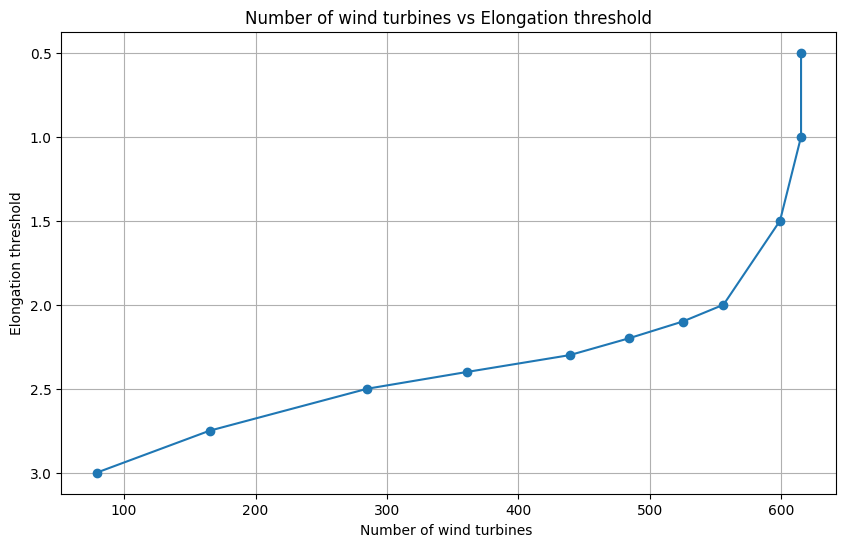

In [1]:
import matplotlib.pyplot as plt

elongation_thresholds = [3.0, 2.75, 2.5, 2.4, 2.3, 2.2, 2.1, 2.0, 1.5, 1.0, 0.5]
number_of_wind_turbines = [79, 165, 285, 361, 439, 484, 525, 556, 599, 615, 615]

plt.figure(figsize=(10, 6))
plt.plot(number_of_wind_turbines, elongation_thresholds, marker='o')
plt.title('Number of wind turbines vs Elongation threshold')
plt.xlabel('Number of wind turbines ')
plt.ylabel('Elongation threshold')
plt.grid()
plt.gca().invert_yaxis() 
plt.show()